In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 1
commitnumber = d5931a1
conc = None
dv = 0.02
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 50
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 294
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

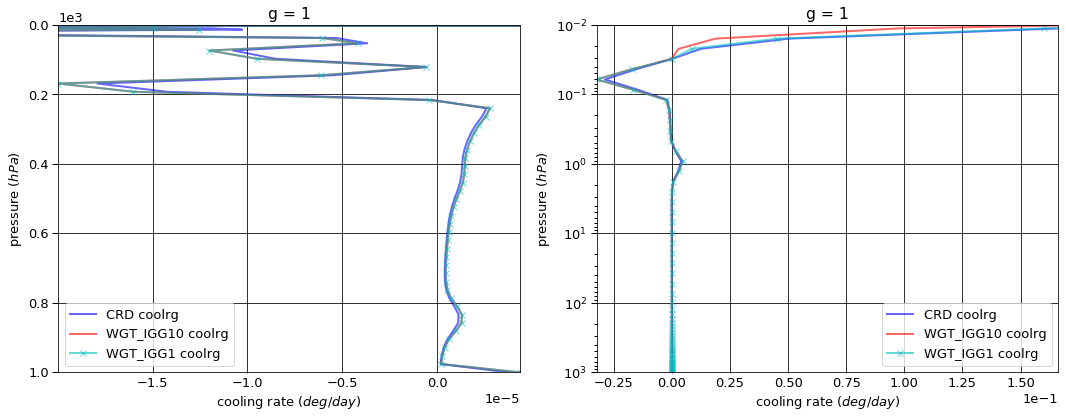

# Figure: cooling rate g-group 2

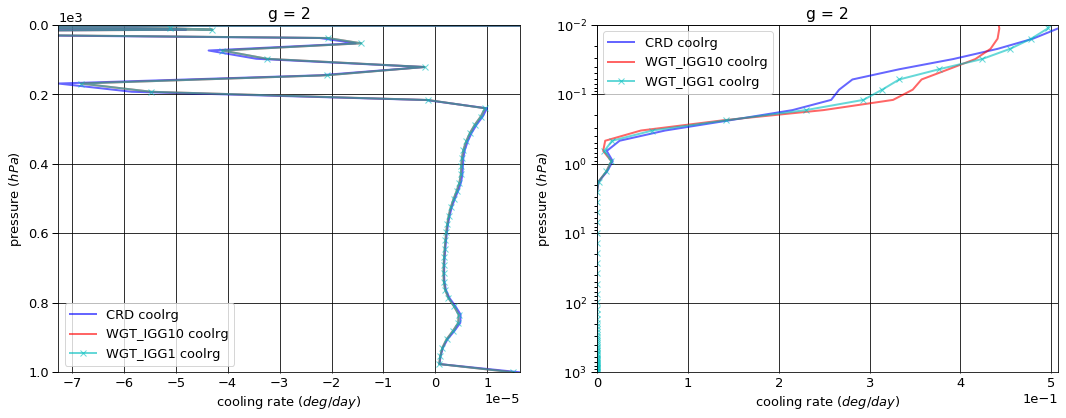

# Figure: cooling rate g-group 3

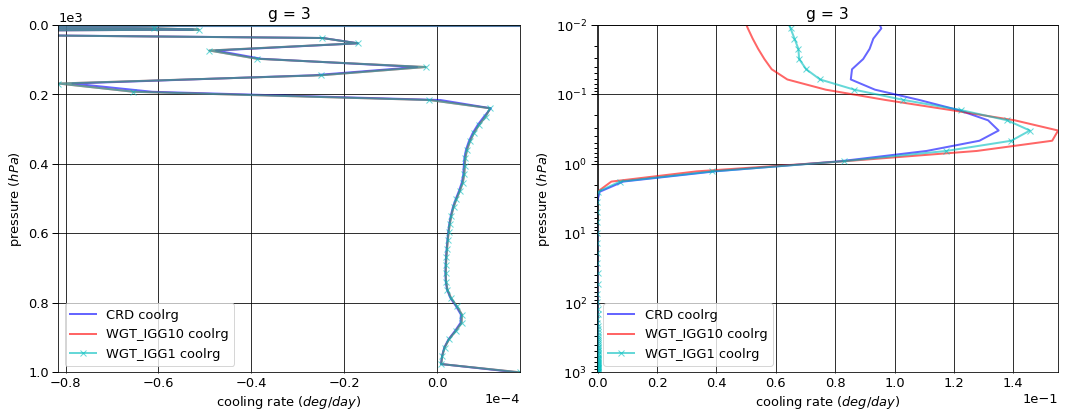

# Figure: cooling rate g-group 4

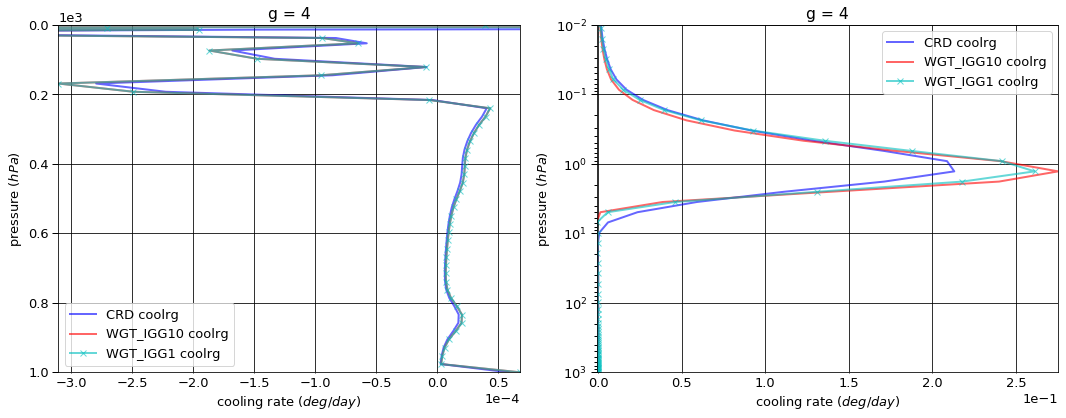

# Figure: cooling rate g-group 5

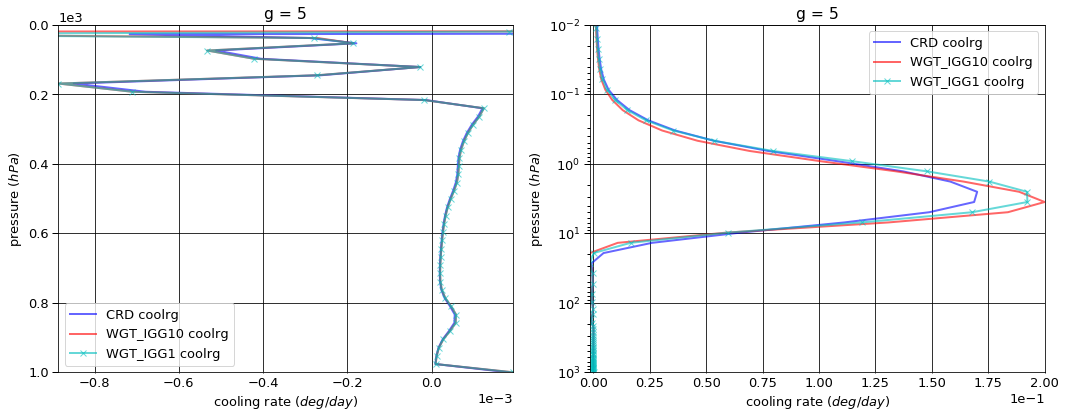

# Figure: cooling rate g-group 6

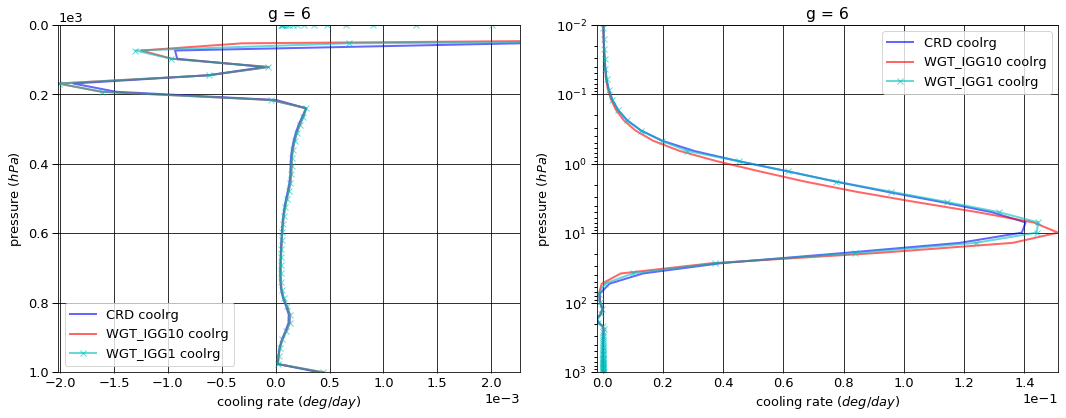

# Figure: cooling rate g-group 7

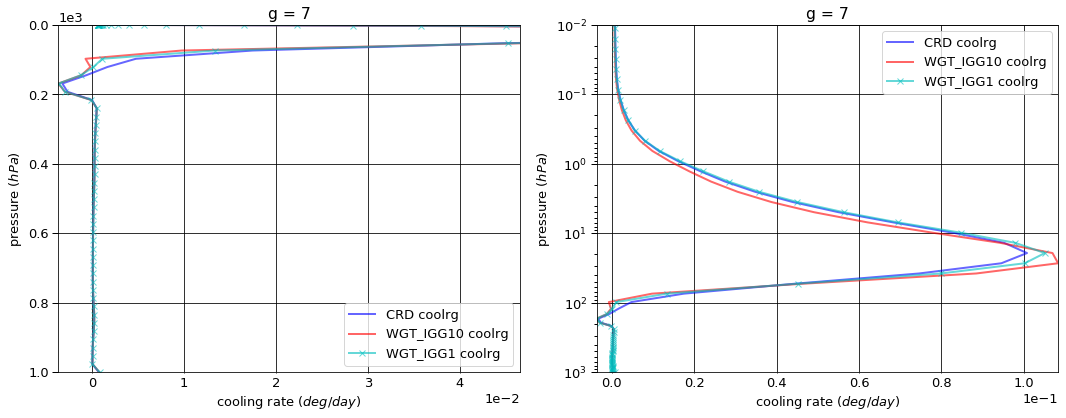

# Figure: cooling rate g-group 8

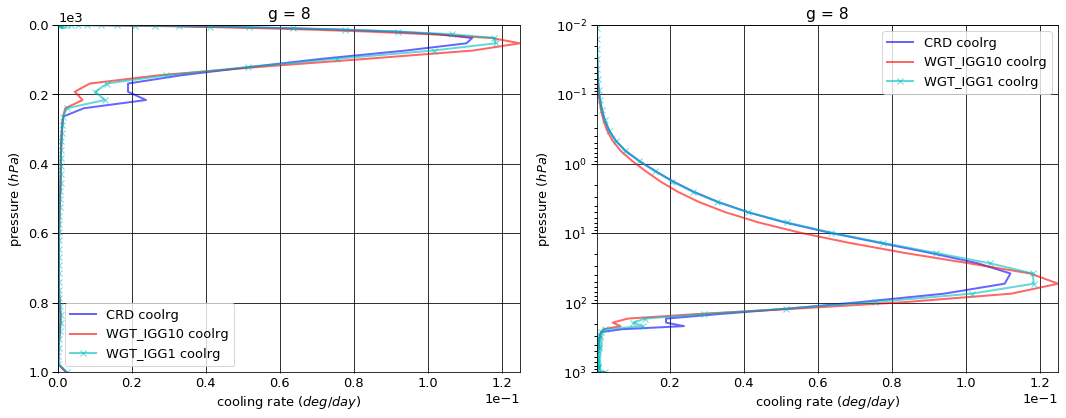

# Figure: cooling rate g-group 9

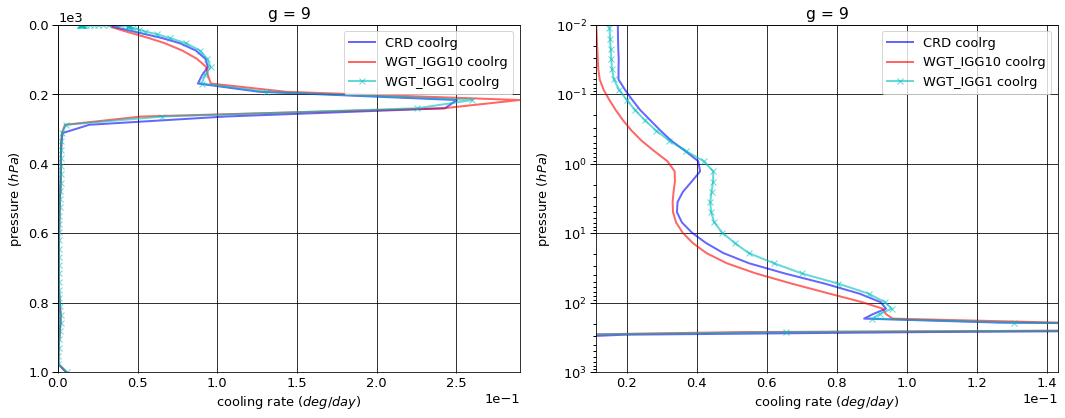

# Figure: cooling rate g-group 10

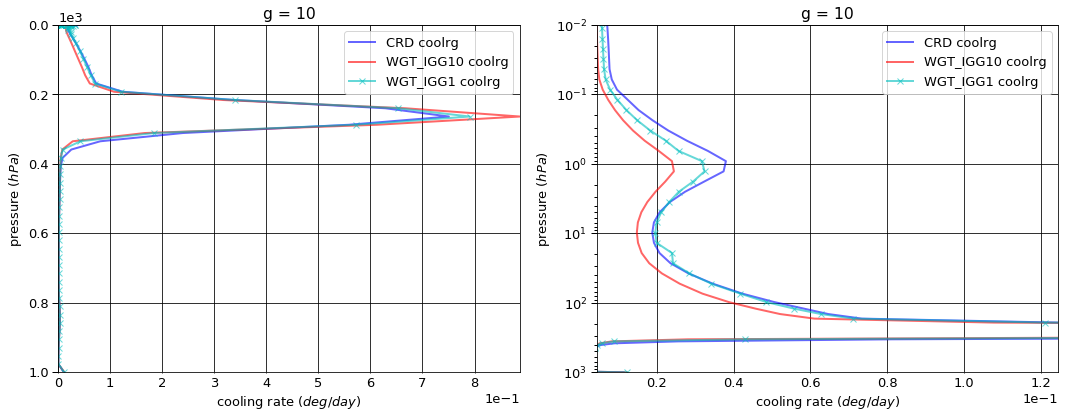

# Figure: cooling rate g-group 11

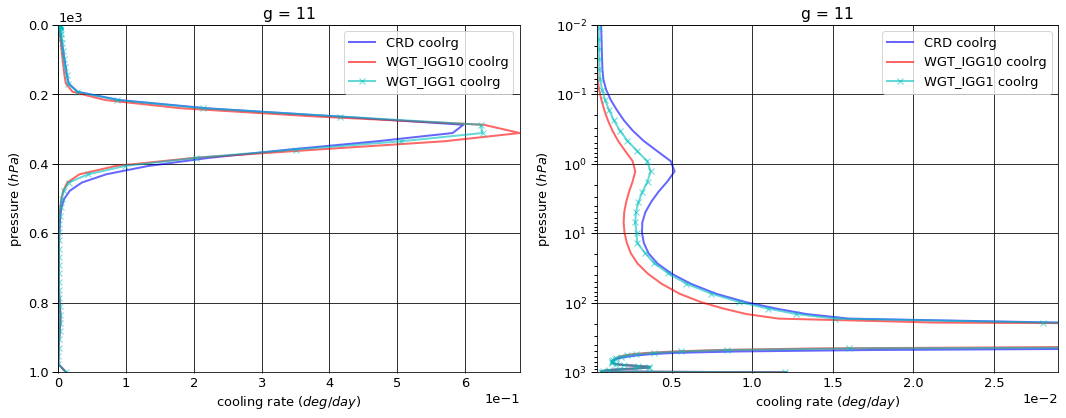

# Figure: cooling rate g-group 12

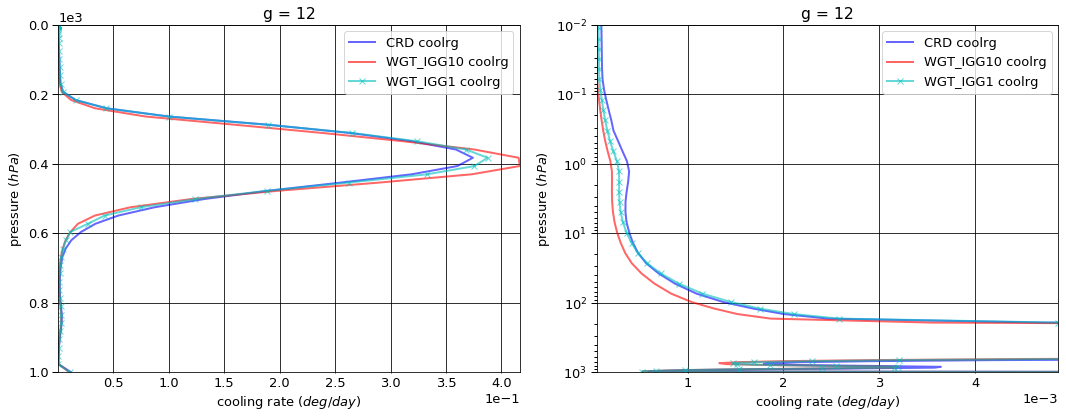

# Figure: cooling rate g-group total

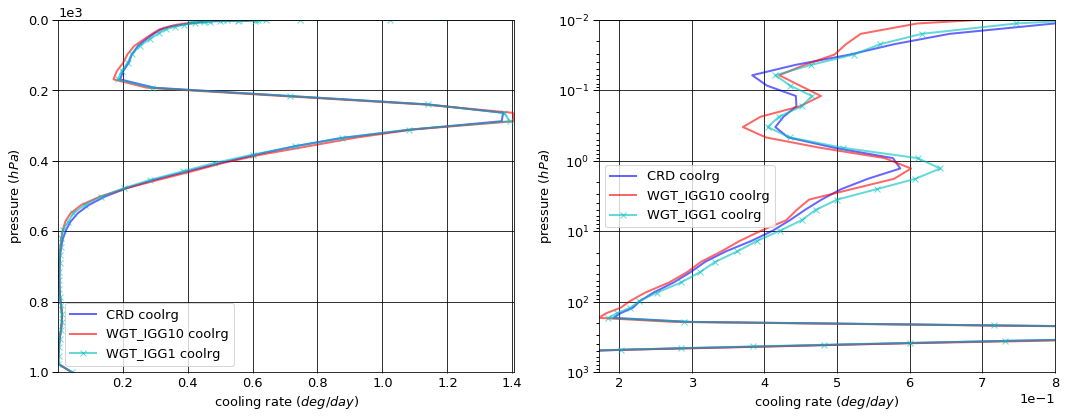

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002842   0.000000 -0.002842
   1013.0   76     -0.004856   0.004846 -0.000010
2  0.0      1      -0.010622   0.000000 -0.010622
   1013.0   76     -0.017538   0.017493 -0.000045
3  0.0      1      -0.015595   0.000000 -0.015595
   1013.0   76     -0.020304   0.020257 -0.000047
4  0.0      1      -0.063753   0.000000 -0.063753
   1013.0   76     -0.075602   0.075440 -0.000161
5  0.0      1      -0.165891   0.000000 -0.165891
   1013.0   76     -0.220032   0.219529 -0.000503
6  0.0      1      -0.342335   0.000000 -0.342335
   1013.0   76     -0.497068   0.495960 -0.001109
7  0.0      1      -0.581663   0.000000 -0.581663
   1013.0   76     -0.914889   0.912842 -0.002047
8  0.0      1      -1.638549   0.000000 -1.638549
   1013.0   76     -2.699140   2.693074 -0.006067
9  0.0      1      -3.914256   0.000000 -3.914256
   1013.0   76     -6.322916   6.308729 -0.014187
10 0.0      1      -8.994547   0.000000 -8.994547
   1013.0   76    -13.773340  13.742102 -0.031238
11 0.0      1      -9.488851   0.000000 -9.488851
   1013.0   76    -13.880725  13.847313 -0.033412
12 0.0      1      -9.041065   0.000000 -9.041065
   1013.0   76    -12.647018  12.613774 -0.033244


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002725   0.000000 -0.002725
   1013.0   76     -0.005025   0.005013 -0.000012
2  0.0      1      -0.010693   0.000000 -0.010693
   1013.0   76     -0.017172   0.017131 -0.000041
3  0.0      1      -0.015809   0.000000 -0.015809
   1013.0   76     -0.020520   0.020471 -0.000049
4  0.0      1      -0.065767   0.000000 -0.065767
   1013.0   76     -0.078114   0.077927 -0.000187
5  0.0      1      -0.167893   0.000000 -0.167893
   1013.0   76     -0.222939   0.222406 -0.000533
6  0.0      1      -0.340298   0.000000 -0.340298
   1013.0   76     -0.507401   0.506188 -0.001213
7  0.0      1      -0.574574   0.000000 -0.574574
   1013.0   76     -0.932988   0.930758 -0.002230
8  0.0      1      -1.602645   0.000000 -1.602645
   1013.0   76     -2.749228   2.742657 -0.006571
9  0.0      1      -3.827237   0.000000 -3.827237
   1013.0   76     -6.443127   6.427727 -0.015400
10 0.0      1      -8.905519   0.000000 -8.905519
   1013.0   76    -13.990484  13.957046 -0.033438
11 0.0      1      -9.490097   0.000000 -9.490097
   1013.0   76    -13.849500  13.816399 -0.033101
12 0.0      1      -9.081532   0.000000 -9.081532
   1013.0   76    -12.256931  12.227636 -0.029295


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002727   0.000000 -0.002727
   1013.0   76     -0.005025   0.005013 -0.000012
2  0.0      1      -0.010750   0.000000 -0.010750
   1013.0   76     -0.017172   0.017131 -0.000041
3  0.0      1      -0.015790   0.000000 -0.015790
   1013.0   76     -0.020520   0.020471 -0.000049
4  0.0      1      -0.065452   0.000000 -0.065452
   1013.0   76     -0.078114   0.077927 -0.000187
5  0.0      1      -0.167721   0.000000 -0.167721
   1013.0   76     -0.222939   0.222406 -0.000533
6  0.0      1      -0.340502   0.000000 -0.340502
   1013.0   76     -0.507401   0.506188 -0.001213
7  0.0      1      -0.575258   0.000000 -0.575258
   1013.0   76     -0.932988   0.930758 -0.002230
8  0.0      1      -1.607397   0.000000 -1.607397
   1013.0   76     -2.749228   2.742657 -0.006571
9  0.0      1      -3.828813   0.000000 -3.828813
   1013.0   76     -6.443127   6.427727 -0.015400
10 0.0      1      -8.875032   0.000000 -8.875032
   1013.0   76    -13.990484  13.957046 -0.033438
11 0.0      1      -9.454397   0.000000 -9.454397
   1013.0   76    -13.849500  13.816399 -0.033101
12 0.0      1      -9.042622   0.000000 -9.042622
   1013.0   76    -12.256931  12.227636 -0.029295


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000117  0.000000  0.000117
   1013.0   76    -0.000169  0.000167 -0.000002
2  0.0      1     -0.000071  0.000000 -0.000071
   1013.0   76     0.000365 -0.000362  0.000004
3  0.0      1     -0.000215  0.000000 -0.000215
   1013.0   76    -0.000216  0.000214 -0.000002
4  0.0      1     -0.002013  0.000000 -0.002013
   1013.0   76    -0.002512  0.002487 -0.000025
5  0.0      1     -0.002002  0.000000 -0.002002
   1013.0   76    -0.002906  0.002877 -0.000029
6  0.0      1      0.002037  0.000000  0.002037
   1013.0   76    -0.010332  0.010228 -0.000104
7  0.0      1      0.007089  0.000000  0.007089
   1013.0   76    -0.018099  0.017916 -0.000183
8  0.0      1      0.035904  0.000000  0.035904
   1013.0   76    -0.050088  0.049584 -0.000504
9  0.0      1      0.087019  0.000000  0.087019
   1013.0   76    -0.120210  0.118998 -0.001212
10 0.0      1      0.089028  0.000000  0.089028
   1013.0   76    -0.217144  0.214944 -0.002200
11 0.0      1     -0.001246  0.000000 -0.001246
   1013.0   76     0.031225 -0.030914  0.000311
12 0.0      1     -0.040467  0.000000 -0.040467
   1013.0   76     0.390087 -0.386138  0.003949


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000115  0.000000  0.000115
   1013.0   76    -0.000169  0.000167 -0.000002
2  0.0      1     -0.000128  0.000000 -0.000128
   1013.0   76     0.000365 -0.000362  0.000004
3  0.0      1     -0.000195  0.000000 -0.000195
   1013.0   76    -0.000216  0.000214 -0.000002
4  0.0      1     -0.001698  0.000000 -0.001698
   1013.0   76    -0.002512  0.002487 -0.000025
5  0.0      1     -0.001830  0.000000 -0.001830
   1013.0   76    -0.002906  0.002877 -0.000029
6  0.0      1      0.001834  0.000000  0.001834
   1013.0   76    -0.010332  0.010228 -0.000104
7  0.0      1      0.006405  0.000000  0.006405
   1013.0   76    -0.018099  0.017916 -0.000183
8  0.0      1      0.031152  0.000000  0.031152
   1013.0   76    -0.050088  0.049584 -0.000504
9  0.0      1      0.085443  0.000000  0.085443
   1013.0   76    -0.120210  0.118998 -0.001212
10 0.0      1      0.119515  0.000000  0.119515
   1013.0   76    -0.217144  0.214944 -0.002200
11 0.0      1      0.034455  0.000000  0.034455
   1013.0   76     0.031225 -0.030914  0.000311
12 0.0      1     -0.001556  0.000000 -0.001556
   1013.0   76     0.390087 -0.386138  0.003949

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer           
1  0.000312    1      10.924221
   1001.112500 75      0.000004
2  0.000312    1       0.533014
   1001.112500 75      0.000016
3  0.000312    1       0.086713
   1001.112500 75      0.000017
4  0.000312    1       0.000049
   1001.112500 75      0.000059
5  0.000312    1       0.000996
   1001.112500 75      0.000183
6  0.000312    1       0.000046
   1001.112500 75      0.000403
7  0.000312    1       0.000652
   1001.112500 75      0.000744
8  0.000312    1       0.000180
   1001.112500 75      0.002205
9  0.000312    1       0.016121
   1001.112500 75      0.005156
10 0.000312    1       0.005952
   1001.112500 75      0.011352
11 0.000312    1       0.000489
   1001.112500 75      0.012139
12 0.000312    1       0.000086
   1001.112500 75      0.012075


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      8.483314
   1001.112500 75     0.000004
2  0.000312    1      0.386005
   1001.112500 75     0.000015
3  0.000312    1      0.041019
   1001.112500 75     0.000018
4  0.000312    1      0.000031
   1001.112500 75     0.000068
5  0.000312    1      0.000636
   1001.112500 75     0.000194
6  0.000312    1      0.000043
   1001.112500 75     0.000441
7  0.000312    1      0.000523
   1001.112500 75     0.000810
8  0.000312    1      0.000141
   1001.112500 75     0.002387
9  0.000312    1      0.010388
   1001.112500 75     0.005595
10 0.000312    1      0.003624
   1001.112500 75     0.012149
11 0.000312    1      0.000269
   1001.112500 75     0.012027
12 0.000312    1      0.000044
   1001.112500 75     0.010644


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      9.027561
   1001.112500 75     0.000004
2  0.000312    1      0.476440
   1001.112500 75     0.000015
3  0.000312    1      0.054963
   1001.112500 75     0.000018
4  0.000312    1      0.000039
   1001.112500 75     0.000068
5  0.000312    1      0.000717
   1001.112500 75     0.000194
6  0.000312    1      0.000049
   1001.112500 75     0.000441
7  0.000312    1      0.000603
   1001.112500 75     0.000810
8  0.000312    1      0.000165
   1001.112500 75     0.002387
9  0.000312    1      0.013797
   1001.112500 75     0.005595
10 0.000312    1      0.004809
   1001.112500 75     0.012149
11 0.000312    1      0.000373
   1001.112500 75     0.012027
12 0.000312    1      0.000062
   1001.112500 75     0.010644


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.440907e+00
   1001.112500 75     6.210811e-07
2  0.000312    1     -1.470089e-01
   1001.112500 75    -1.349138e-06
3  0.000312    1     -4.569432e-02
   1001.112500 75     7.703280e-07
4  0.000312    1     -1.776854e-05
   1001.112500 75     9.203879e-06
5  0.000312    1     -3.597961e-04
   1001.112500 75     1.066575e-05
6  0.000312    1     -2.258102e-06
   1001.112500 75     3.774613e-05
7  0.000312    1     -1.282844e-04
   1001.112500 75     6.636366e-05
8  0.000312    1     -3.923364e-05
   1001.112500 75     1.827216e-04
9  0.000312    1     -5.732480e-03
   1001.112500 75     4.392814e-04
10 0.000312    1     -2.328887e-03
   1001.112500 75     7.970760e-04
11 0.000312    1     -2.205036e-04
   1001.112500 75    -1.126270e-04
12 0.000312    1     -4.263960e-05
   1001.112500 75    -1.430669e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.896660e+00
   1001.112500 75     6.210811e-07
2  0.000312    1     -5.657458e-02
   1001.112500 75    -1.349138e-06
3  0.000312    1     -3.174959e-02
   1001.112500 75     7.703280e-07
4  0.000312    1     -1.015920e-05
   1001.112500 75     9.203879e-06
5  0.000312    1     -2.791258e-04
   1001.112500 75     1.066575e-05
6  0.000312    1      3.255922e-06
   1001.112500 75     3.774613e-05
7  0.000312    1     -4.825075e-05
   1001.112500 75     6.636366e-05
8  0.000312    1     -1.554982e-05
   1001.112500 75     1.827216e-04
9  0.000312    1     -2.323554e-03
   1001.112500 75     4.392814e-04
10 0.000312    1     -1.143875e-03
   1001.112500 75     7.970760e-04
11 0.000312    1     -1.156643e-04
   1001.112500 75    -1.126270e-04
12 0.000312    1     -2.461388e-05
   1001.112500 75    -1.430669e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.259971,0.000000,-34.259971
1013.0,76,-51.073429,50.951359,-0.122070



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.084790,0.00000,-34.08479
1013.0,76,-51.073429,50.95136,-0.12207



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.986460,0.00000,-33.98646
1013.0,76,-51.073429,50.95136,-0.12207



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.751810e-01,0.000000,1.751810e-01
1013.0,76,-1.054000e-07,0.000001,5.858020e-07



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.735115e-01,0.000000,2.735115e-01
1013.0,76,-1.054000e-07,0.000001,5.858020e-07


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,11.568520
1001.112500,75,0.044352



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,8.926038
1001.112500,75,0.044352



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,9.579578
1001.112500,75,0.044352



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.642482e+00
1001.112500,75,-1.953099e-07



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.988942e+00
1001.112500,75,-1.953099e-07


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000250,0.000336
3,0.000500,0.000402
4,0.001875,0.001529
5,0.004750,0.004365
6,0.012188,0.009935
7,0.020625,0.018268
8,0.064562,0.053829
9,0.150812,0.126154


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.428976e-16
2,5.434972e-17
3,8.614503e-18
4,1.160099e-17
5,2.152872e-18
6,3.995224e-19
7,6.708836e-19
8,1.270181e-19
9,2.404829e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.428976e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,5.434972e-17,0.158501,0.000250,0.000336,0.000375,0.000435,1.0
3,8.614503e-18,0.158501,0.000500,0.000402,0.000875,0.000836,1.0
4,1.160099e-17,1.346682,0.001875,0.001529,0.002750,0.002366,30.0
5,2.152872e-18,0.185577,0.004750,0.004365,0.007500,0.006731,30.0
6,3.995224e-19,0.185577,0.012188,0.009935,0.019688,0.016666,30.0
7,6.708836e-19,1.679214,0.020625,0.018268,0.040313,0.034933,300.0
8,1.270181e-19,0.189330,0.064562,0.053829,0.104875,0.088762,300.0
9,2.404829e-20,0.189330,0.150812,0.126154,0.255687,0.214916,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
